In [ ]:
import os
from torchvision import datasets , transforms
from torch.utils.data import DataLoader , random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt
import optuna

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/damage-prediction/training/dataset"

In [ ]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456,0.406], std =[0.229,0.224,0.225])
])

In [ ]:
dataset = datasets.ImageFolder( data_path ,transform=image_transforms )
len(dataset)

2300

In [ ]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [ ]:
num_classes = len(dataset.classes)
num_classes

6

In [ ]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size , val_size

(1725, 575)

In [ ]:
train_size = int(0.75*len(dataset))
train_dataset , val_dataset  = random_split(dataset , [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle= False)


In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
labels[0]

tensor(2)

In [ ]:
images[0].shape

torch.Size([3, 224, 224])

In [ ]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

<function matplotlib.pyplot.show(close=None, block=None)>

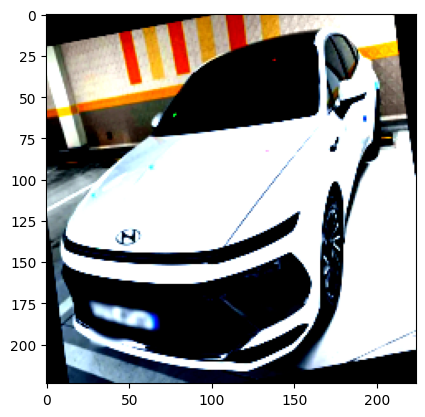

In [ ]:
plt.imshow(images[5].permute(1,2,0))
plt.show

#  Model 1: **CNN**




In [ ]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #(16, 224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(16,112,112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), #(32, 112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(32,56,56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #(64, 56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64,28,28)

            nn.Flatten(),
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Linear(512 ,num_classes),
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [ ]:
# Instantiate the model, loss function and optimizer

model = CarClassifierCNN(num_classes = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001)

In [ ]:
len(train_loader.dataset)

1725

In [ ]:
def train_model(model ,criterion,optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):

            #Zero the gradients parameters
            optimizer.zero_grad()

            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Backward pass and Optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 ==0:
                print(f'Batch: {batch_num+1}, Epoch:{epoch+1}, Loss:{loss.item():0.2f}')

            running_loss += loss.item()*images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch:[{epoch+1}/{epochs}],Avg Loss:{epoch_loss:.4f}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels =[]
        all_predicted = []

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data , 1)
                total += labels.size(0)
                correct += (predicted == labels ).sum().item()
                all_labels.extend(labels.numpy())
                all_predicted.extend(predicted.numpy())

            print(f'**** Validation Accuracy :{100 * correct/ total:.2f}% *****')

    end = time.time()
    print(f'Execution time: {end - start} seconds')
    return all_labels, all_predicted


In [ ]:
train_model(model ,criterion,optimizer, epochs= 2)

Batch: 10, Epoch:1, Loss:1.77
Batch: 20, Epoch:1, Loss:1.75
Batch: 30, Epoch:1, Loss:1.63
Batch: 40, Epoch:1, Loss:1.37
Batch: 50, Epoch:1, Loss:1.49
Epoch:[1/2],Avg Loss:1.6527
**** Validation Accuracy :38.26% *****
Batch: 10, Epoch:2, Loss:1.62
Batch: 20, Epoch:2, Loss:1.10
Batch: 30, Epoch:2, Loss:1.55
Batch: 40, Epoch:2, Loss:1.21
Batch: 50, Epoch:2, Loss:1.01
Epoch:[2/2],Avg Loss:1.2969
**** Validation Accuracy :52.87% *****
Execution time: 890.9164216518402 seconds


([np.int64(4),
  np.int64(1),
  np.int64(1),
  np.int64(5),
  np.int64(5),
  np.int64(0),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(1),
  np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(3),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(1),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(2),
  np.int64(3),
  np.int64(5),
  np.int64(1),
  np.int64(1),
  np.int64(4),
  np.int64(4),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(3),
  np.int64

**Adding Regularization to Model Training**

# Model 2: CNN with Regularization

In [ ]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #(16, 224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(16,112,112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), #(32, 112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(32,56,56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #(64, 56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64,28,28)

            nn.Flatten(),
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512 ,num_classes),
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [ ]:
# Instantiate the model, loss function and optimizer

model = CarClassifierCNNWithRegularization(num_classes = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001, weight_decay = 1e-4)


train_model(model ,criterion,optimizer, epochs= 10)

Batch: 10, Epoch:1, Loss:9.85
Batch: 20, Epoch:1, Loss:4.98
Batch: 30, Epoch:1, Loss:1.87
Batch: 40, Epoch:1, Loss:1.54
Batch: 50, Epoch:1, Loss:1.33
Epoch:[1/10],Avg Loss:7.0635
**** Validation Accuracy :50.78% *****
Batch: 10, Epoch:2, Loss:1.30
Batch: 20, Epoch:2, Loss:1.41
Batch: 30, Epoch:2, Loss:1.16
Batch: 40, Epoch:2, Loss:1.21
Batch: 50, Epoch:2, Loss:1.33
Epoch:[2/10],Avg Loss:1.3222
**** Validation Accuracy :50.78% *****
Batch: 10, Epoch:3, Loss:1.58
Batch: 20, Epoch:3, Loss:1.10
Batch: 30, Epoch:3, Loss:1.49
Batch: 40, Epoch:3, Loss:1.29
Batch: 50, Epoch:3, Loss:1.07
Epoch:[3/10],Avg Loss:1.2633
**** Validation Accuracy :49.74% *****


KeyboardInterrupt: 

# Model 3: Transfer Learning with EfficientNet

In [ ]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier= nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)

        )

    def forward(self,x):
        x = self.model(x)
        return x

In [ ]:
# Instantiate the model, loss function and optimizer

model = CarClassifierEfficientNet(num_classes = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()) , lr = 0.001)


train_model(model ,criterion,optimizer, epochs= 10)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 50.0MB/s]


Batch: 10, Epoch:1, Loss:1.61
Batch: 20, Epoch:1, Loss:1.55
Batch: 30, Epoch:1, Loss:1.50
Batch: 40, Epoch:1, Loss:1.42
Batch: 50, Epoch:1, Loss:1.21
Epoch:[1/10],Avg Loss:1.4774
**** Validation Accuracy :55.83% *****
Batch: 10, Epoch:2, Loss:1.40
Batch: 20, Epoch:2, Loss:1.23
Batch: 30, Epoch:2, Loss:1.28
Batch: 40, Epoch:2, Loss:1.03
Batch: 50, Epoch:2, Loss:1.09
Epoch:[2/10],Avg Loss:1.1395
**** Validation Accuracy :65.57% *****
Batch: 10, Epoch:3, Loss:1.07
Batch: 20, Epoch:3, Loss:1.03
Batch: 30, Epoch:3, Loss:1.05
Batch: 40, Epoch:3, Loss:1.04
Batch: 50, Epoch:3, Loss:1.03
Epoch:[3/10],Avg Loss:1.0090
**** Validation Accuracy :65.74% *****
Batch: 10, Epoch:4, Loss:0.86
Batch: 20, Epoch:4, Loss:0.89
Batch: 30, Epoch:4, Loss:1.06
Batch: 40, Epoch:4, Loss:0.89
Batch: 50, Epoch:4, Loss:0.79
Epoch:[4/10],Avg Loss:0.9514
**** Validation Accuracy :63.83% *****
Batch: 10, Epoch:5, Loss:0.82
Batch: 20, Epoch:5, Loss:0.87
Batch: 30, Epoch:5, Loss:0.70
Batch: 40, Epoch:5, Loss:0.77
Batch: 5

#  Model 4: Transfer Learning with ResNet

In [ ]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer 4 and fully connected layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True


        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [ ]:
# Instantiate the model, loss function and optimizer

model = CarClassifierResNet(num_classes = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()) , lr = 0.001)


train_model(model ,criterion,optimizer, epochs= 10)